<a href="https://colab.research.google.com/github/rajpaul8/SatelliteImageClassification/blob/main/RF_Classifier_Using_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING MODULES

In [5]:
import os
import glob
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import numpy as np
import gdal
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

Fetching The Imageries From the Path

In [7]:
#Input Dir
path_of_unstackedBands = r"/content/Khushboo/DelhiDataset"
search_Tif_With_Init = "B*.tif"
FetchRasterBands = os.path.join(path_of_unstackedBands,search_Tif_With_Init)
getListOfFetchedBands = glob.glob(FetchRasterBands)
#print(getListOfFetchedBands)
getListOfFetchedBands.sort()

#Write Output Here:
output_dir = "/content/Khushboo/Output"
raster_out_path = os.path.join(output_dir, "Stacked_Raster.tif")



Stacking Multiple Imageries into One Image with Multibands

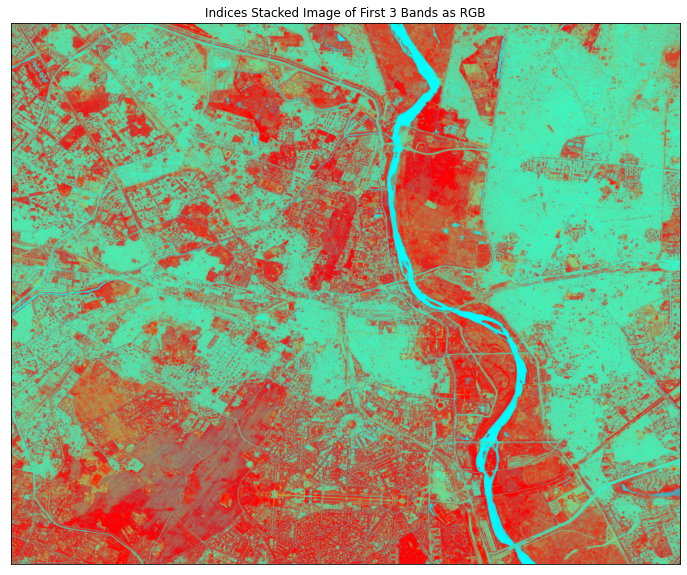

In [8]:
array, raster_prof = es.stack(getListOfFetchedBands, out_path=raster_out_path)
#Create Extent
extent = plotting_extent(array[0], raster_prof["transform"])

#Plot and See
fig, ax = plt.subplots(figsize=(12, 12))
ep.plot_rgb(
    array,
    ax=ax,
    stretch=True,
    extent=extent,
    str_clip=0.5,
    title="Indices Stacked Image of First 3 Bands as RGB",
)
plt.show()

In [9]:
# Removing No Data
array_nodata, raster_prof_nodata = es.stack(getListOfFetchedBands, nodata=-9999)
""" View hist of data with nodata values removed
ep.hist(
    array_nodata,
    title=[
        "Band 1 - No Data Values Removed",
        "Band 2 - No Data Values Removed",
        "Band 3 - No Data Values Removed",
        "Band 4 - No Data Values Removed", 
    ],
)
plt.show()
"""
# Recreate extent object for the No Data array

extent_nodata = plotting_extent(
    array_nodata[0], raster_prof_nodata["transform"]
)

RF_Classifier

In [14]:
#Define The Input and Output Path

inpRaster = '/content/Khushboo/Output/Stacked_Raster.tif' 

outClassifiedRaster = '/content/Khushboo/Output/RF_Classified_2.tif'

#Read Training Sample csv file
df = pd.read_csv('/content/Khushboo/TrainingSample/SelectedPointRasterBandStats.csv', delimiter=',')
# To see the Column name for inputing the band name reference below use -- > df.head()
#enter training data bands according to your csv columns name
data = df[['Band1','Band2','Band3','Band4']]
#enter training label according to your csv column name
label = df['Decision']
del df

#No Changes Required Beyond This Point ----

#open raster
ds = gdal.Open(inpRaster, gdal.GA_ReadOnly)

#get raster info
rows = ds.RasterYSize
cols = ds.RasterXSize
bands = ds.RasterCount
geo_transform = ds.GetGeoTransform()
projection = ds.GetProjectionRef()

#read as array
array = ds.ReadAsArray()

ds = None

# #modify structure
array = np.stack(array,axis=2)
array = np.reshape(array, [rows*cols,bands])
test = pd.DataFrame(array, dtype='float32')
# del array

# #set classifier parameters and train classifier --> Using 50 Trees and n_jobs = -1 => All the processors to make prediction in higher efficiency 
clf = RandomForestClassifier(n_estimators=50,n_jobs=-1,oob_score=True)
clf.fit(data,label)
del data
del label
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=clf.oob_score_ * 100))
bands = [1, 2, 3, 4]

for b, imp in zip(bands, clf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

# #predict classes
y_pred = clf.predict(test)
del test
classification = y_pred.reshape((rows,cols))
del y_pred

def createGeotiff(outRaster, data, geo_transform, projection):
    # Create a GeoTIFF file with the given data
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    rasterDS = driver.Create(outRaster, cols, rows, 1, gdal.GDT_Int32)
    rasterDS.SetGeoTransform(geo_transform)
    rasterDS.SetProjection(projection)
    band = rasterDS.GetRasterBand(1)
    band.WriteArray(data)
    rasterDS = None


#export classified image
createGeotiff(outClassifiedRaster,classification,geo_transform,projection)


Our OOB prediction of accuracy is: 0.0%
Band 1 importance: 0.28472222222222215
Band 2 importance: 0.23472222222222228
Band 3 importance: 0.17500000000000002
Band 4 importance: 0.3055555555555555
